In [1]:
from pathlib import Path
import re
import pickle
import numpy as np
import xarray as xr
import pandas as pd
import torch
from tqdm.auto import tqdm
import torchlens as tl

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
sns.set_palette("Set2")

sns.set_theme(
    context="paper",
    style="white",
    rc={
        "figure.dpi": 100, "savefig.dpi": 600,
        "savefig.bbox": "tight",
        "figure.labelsize": "small",
    }
)

import os
from dotenv import load_dotenv
load_dotenv()

from lib.utils.binning import *
from lib.analyses.yield_models import yield_models, load_yielder
from itertools import combinations, permutations
from bonner.computation.metrics import pearson_r
from bonner.computation.decomposition import PCA
from sklearn.linear_model import RidgeCV
from bonner.caching import BONNER_CACHING_HOME, cache
from bonner.datasets.allen2021_natural_scenes._stimuli import load_stimulus_metadata

from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=UserWarning, message='Log scale')
warnings.filterwarnings('ignore', category=UserWarning, message='The palette')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='The data contains')

Help functions

In [2]:
root = BONNER_CACHING_HOME / "summary_results"

def _yielder_id(idx=[0, 1, 2, 3], label=False):
    if not label:
        l = [
            "resnet18_classification_imagenet1k_varied_seeds",
            "classification_imagenet1k_varied_architectures",
            "resnet50_imagenet1k_varied_tasks",
            "untrained_resnet18_varied_seeds",
            "varied_visual_diets",
        ]
    else:
        l = [
            "Different initializations",
            "Different architectures",
            "Different tasks",
            "Untrained",
            "Different visual diets",
        ]
    if isinstance(idx, int):
        return l[idx]
    else:
        return [l[i] for i in idx]

def _relative_node_depths():
    path = Path(f"{os.getcwd()}/node_depth_dicts/all.pkl")
    if path.exists():
        return
    yield_id = _yielder_id(idx=1)
    dct = {}
    yielder = load_yielder(yield_id)
    x = torch.rand(2, 3, 224, 224)
    for model in tqdm(yield_models(yielder), desc="model", leave=False):
        architecture = model.identifier.split(".")[0]
        if architecture in dct.keys():
            continue
        dct[architecture] = {}
        model_history = tl.log_forward_pass(model.model, x, layers_to_save=None)
        for node in model.nodes:
            tnode = node
            key_index = 0
            while len(tnode.split(".")) > 0:
                if len(model_history.module_layers[tnode]) > 0:
                    break
                else:
                    try:
                        match = re.search(r'[\W_]\d+$', tnode)
                        key_index = int(re.split(r'[\W_]', tnode)[-1])
                    except:
                        match = re.search(r'[\W]\w+$', node)
                    tnode = tnode[:match.start()]
            dct[architecture][node] = float(model_history.module_layers[tnode][key_index].split("_")[-1])/model_history.num_operations
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump(dct, f,)

def _add_node_depths(df):
    _relative_node_depths()
    path = f"{os.getcwd()}/node_depth_dicts/all.pkl"
    with open(path, "rb") as f:
        dct = pickle.load(f,)
    df["node_depth"] = [dct[df.model.iloc[i].split(".")[0]][df.node.iloc[i]] for i in range(len(df))]
    return df

def _load_main_results(yield_idx, basis, mode, roi="general", reg="ridgecv", individual_subj=False, postfix="", sr=False):
    mode_dict = {"NSD": "shared", "NSD.shared": "same", "RP": "RP",}
    if isinstance(yield_idx, int):
        yield_idx = [yield_idx]
    yielders, sets = _yielder_id(yield_idx), _yielder_id(yield_idx, label=True)
    X = []
    for i in range(len(yielders)):
        x = [
            xr.open_dataarray(root / f"brain_similarity/brain_similarity{postfix}.regression={reg}.basis={basis}.roi={roi}.mode={mode_dict[mode]}.yielder={yielders[i]}.nc").to_dataset(name="brain_similarity"),
            xr.open_dataarray(root / f"universality_index/universality_index{postfix}.basis={basis}.type=within_basis.regression={reg}.mode={mode}.yielder={yielders[i]}.nc").to_dataset(name="within_basis_ui"),
        ]
        
        x[0] = x[0].sel(neuroid=x[0].model!="alexnetgn.weights=ref01")
    
        if sr:
            x.append(xr.open_dataarray(root / f"universality_index/universality_index{postfix}.basis={basis}.type=cross_basis_v2.regression={reg}.roi={roi}.mode={mode}.yielder={yielders[i]}.nc").to_dataset(name="cross_basis_ui"))
        
        if individual_subj:
            x[0] = xr.open_dataarray(root / f"brain_similarity/brain_similarity.regression={reg}.basis={basis}.roi={roi}.mode={mode_dict[mode]}.yielder={yielders[i]}.individual_subj.nc").to_dataset(name="brain_similarity")
            for j in [0,]:
                x[j] = x[j].sortby("subject",)
        if roi in ("default_list"):
            for j in [
                0,
            ]:
                x[j] = x[j].sortby("roi",)
        
        x[1] = xr.DataArray(
            list(x[1].within_basis_ui.values) * int(len(x[0].neuroid) / len(x[1].neuroid)),
            dims="neuroid",
            coords={
                "neuroid": x[0].neuroid.values, 
                "model": ("neuroid", x[0].model.values),
                "node": ("neuroid", x[0].node.values),
                "roi": ("neuroid", x[0].roi.values),
            }
        ).to_dataset(name="within_basis_ui")
        if sr:
            x[2] = xr.DataArray(
                list(x[2].cross_basis_ui.values) * int(len(x[0].neuroid) / len(x[2].neuroid)),
                dims="neuroid",
                coords={
                    "neuroid": x[0].neuroid.values, 
                    "model": ("neuroid", x[0].model.values),
                    "node": ("neuroid", x[0].node.values),
                    "roi": ("neuroid", x[0].roi.values),
                }
            ).to_dataset(name="cross_basis_ui")
        x = xr.merge(x)
        df = x.to_dataframe()    
        if basis == "activation_pc":
            df["pc"] = df.index.values
        df["model_set"] = [sets[i] for _ in df.index]
        df = df.reset_index()
        df["model"] = [str(s) for s in df["model"]]
        df["node"] = [str(s) for s in df["node"]]
        df["brain_similarity"] = [float(s) for s in df["brain_similarity"]]
        df["within_basis_ui"] = [float(s) for s in df["within_basis_ui"]]
        if sr:
            df["cross_basis_ui"] = [float(s) for s in df["cross_basis_ui"]]
        X.append(df)
    return pd.concat(X).reset_index()

def _plot_results_in_grid(
    df, x, y=None,
    main_plots=("line",), n_bin=100, 
    group=None, hue=None, group_order=None, hue_order=None, errorbar=None,
    palette=None, markercolor=None, xlabel=None, ylabel=None, hue_label=None, legend=None,
    rowcol=(1, 4), xylim=(-.2, 1), figname = None,
    color="orange", cmap="mako",
    kde_line=False, bw_adjust=1, thresh=1e-2,
    norm=LogNorm(vmin=1e-2, vmax=1e1),
    log_kde=False, kdelim=(1e-2, 1e1),
    log_x=False, log_y=False,
):
    assert "line" in main_plots
    colorbar = ("density" in main_plots and hue is None) or (hue is not None and hue != "model" and hue != "roi")
    tdf = df.copy().dropna().reset_index()
    if group is None:
        group = "group"
        tdf["group"] = ["" for _ in range(len(tdf))]
    if group_order is None:
        if rowcol == (1, 1):
            group_order = ["all"]
        else:
            group_order = tdf[group].unique().tolist()
    if isinstance(group_order, str):
        group_order = [group_order]
            
    if hue is not None:
        tdf["gh"] = [f"{tdf[group][i]}_{tdf[hue][i]}" for i in range(len(tdf))]
        
    plt.close()
    fig, ax = plt.subplots(
        figsize=(rowcol[1]*5.25+0.25, rowcol[0]*5.25-.75,) if colorbar else (rowcol[1]*5.25-.75, rowcol[0]*5.25-.75,),
        nrows=rowcol[0]*2, ncols=rowcol[1]*2+1 if colorbar else rowcol[1]*2,
        sharex="col", sharey="row",
        gridspec_kw={"height_ratios": [1, 3.5]*rowcol[0], "width_ratios": ([3.5, 1]*rowcol[1] + [.5])} if colorbar else {"height_ratios": [1, 3.5]*rowcol[0], "width_ratios": [3.5, 1]*rowcol[1]},
    )

    tdf = df_quantile_bin(
        df=tdf, col=x,
        label_col=f"{x}_bin",
        n_bin=n_bin,
        level="gh" if hue is not None else group,
    )
    if colorbar:
        for i in range(len(ax)):
            fig.delaxes(ax[i][rowcol[1]*2])     
    for i in range(len(group_order)):
        if rowcol == (1, 1):
            ttdf = tdf
        else:
            ttdf = tdf[tdf[group] == group_order[i]]
        if xylim is not None:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(xlim=xylim, ylim=xylim)
        if xlabel and i//rowcol[1] == rowcol[0]-1:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(xlabel=xlabel)
        if ylabel and i%rowcol[1] == 0:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(ylabel=ylabel) 

        if "scatter" in main_plots:
            sns.scatterplot(
                data=ttdf,
                x=x, y=y, color="slategray",
                s=3, alpha=.33, legend=False,
                ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
            )
            
        if "density" in main_plots:
            if hue is None:
                sns.kdeplot(
                    data=ttdf,
                    x=x, y=y, color="#cacad8",
                    levels=100,
                    cmap=cmap, 
                    fill=True, 
                    legend=False, alpha=.9,
                    norm=norm,
                    bw_adjust=bw_adjust,
                    ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
                    thresh=thresh,
                )
            else:
                for j, h in enumerate(hue_order):
                    sns.kdeplot(
                        data=ttdf[ttdf[hue] == h],
                        x=x, y=y, color=sns.color_palette(palette)[j],
                        levels=3,
                        fill=None, 
                        legend=False, alpha=.9,
                        norm=norm,
                        bw_adjust=bw_adjust,
                        ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
                        thresh=thresh,
                    )
            if kde_line:
                from scipy.stats import gaussian_kde
                kde = gaussian_kde([ttdf[x], ttdf[y]])
                kde.set_bandwidth(kde.factor * bw_adjust)
                lin_x = np.linspace(ttdf[x].min(), ttdf[x].max(), n_bin)
                lin_y = np.linspace(ttdf[y].min(), ttdf[y].max(), n_bin)
                grid_x, grid_y = np.meshgrid(lin_x, lin_y)
                density = kde.evaluate(np.vstack([grid_x.ravel(), grid_y.ravel()])).reshape(grid_x.shape)
                sns.lineplot(
                    x=lin_x, y=lin_y @ density / density.sum(axis=0),
                    hue=hue, palette=palette if hue is not None else None, hue_order=hue_order,
                    style=group if rowcol == (1, 1) else None, dashes=False,
                    ls="None" if hue is None else None, errorbar=errorbar,
                    marker="o", markersize=4, linewidth=1, markeredgewidth=0,
                    markerfacecolor="limegreen" if markercolor is None and hue is None else markercolor,
                    markeredgecolor="limegreen" if markercolor is None and hue is None else markercolor,
                    ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
                )
        
        if log_x:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(xscale="log",)
        if log_y:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(yscale="log",)
                       
        if "diagonal" in main_plots:
            sns.lineplot(x=xylim, y=xylim, color="black", ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2], linewidth=1, linestyle="--")
        
        if markercolor is None:
            if hue is None:
                tcolor = color
            elif hue == "model":
                tcolor = "black"
            else:
                tcolor = None
        else:
            tcolor = markercolor
        
        sns.lineplot(
            data=ttdf,
            x=f"{x}_bin", y=y,
            hue=hue, palette=sns.color_palette([tcolor]) if hue is not None and hue == "model" else palette, hue_order=hue_order,
            style=group if rowcol == (1, 1) else None, dashes=False,
            ls="None" if hue is None else None, 
            errorbar=errorbar,
            marker="o", markersize=3, linewidth=.67, markeredgewidth=0,
            markerfacecolor=tcolor,
            markeredgecolor=tcolor,
            ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
        )
        sns.kdeplot(
            data=ttdf,
            x=x, 
            hue=None if hue is None or hue == "model" else hue,
            palette=palette, hue_order=hue_order,
            legend=False, 
            common_norm=False, 
            color="black" if hue is None or hue == "model" else None,
            ax=ax[(i//rowcol[1])*2][(i%rowcol[1])*2],
        )
        sns.kdeplot(
            data=ttdf,
            y=y,
            hue=None if hue is None or hue == "model" else hue,  
            palette=palette, hue_order=hue_order,
            legend=False, 
            common_norm=False, 
            color="black" if hue is None or hue == "model" else None,
            ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2+1],
        )
        if log_kde:
            ax[(i//rowcol[1])*2][(i%rowcol[1])*2].set(yscale="log", ylim=kdelim, yticks=[1e-2, 1e1])
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2+1].set(xscale="log", xlim=kdelim, xticks=[1e-2, 1e1])
        if hue is not None:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].get_legend().remove()
        fig.delaxes(ax[(i//rowcol[1])*2][(i%rowcol[1])*2+1])
        if rowcol != (1, 1):
            ax[(i//rowcol[1])*2][(i%rowcol[1])*2].set_title(group_order[i])
       
    if hue is not None:
        if isinstance(tdf[hue][0], float):
            sm=plt.cm.ScalarMappable(cmap=palette,)
            sm.set_array([])
            fig.colorbar(
                sm, 
                ax=ax[rowcol[0]//2*2+1][rowcol[1]*2],
                orientation='vertical',
                shrink=.8,
                fraction=1,
                label=hue_label if hue_label is not None else hue,
            )
        elif legend == "roi":
            handles, labels = ax[1, 0].get_legend_handles_labels()
            updated_labels = []
            for label in labels:
                if label.split("-")[0] == "streams":
                    updated_labels.append(label.split("-")[1].capitalize())
                else:
                    updated_labels.append(label.capitalize())
            fig.legend(handles, updated_labels, loc='lower center', ncols=len(tdf[hue].unique()), bbox_to_anchor=(.5, -.1), fontsize="medium")
        elif legend == "model_set":
            handles, labels = ax[1, 0].get_legend_handles_labels()
            ax[1, 0].legend(handles=handles[1:1+len(hue_order)], labels=labels[1:1+len(hue_order)], loc="upper left", fontsize="small",)
            ax[1, 0].get_legend().get_frame().set_linewidth(0)
    
    if "density" in main_plots and hue is None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cb = fig.colorbar(
            sm, 
            ax=ax[rowcol[0]//2*2+1][rowcol[1]*2],
            orientation='vertical',
            shrink=.8,
            fraction=1,
        )
        cb.minorticks_off()
        cb.set_ticks([1e-2, 1e1])
        cb.set_label(label="Density")
    
    sns.despine()
    if figname is not None:
        fig.savefig(f"../../figures/{figname}.png", bbox_inches="tight")

def _plot_results_in_simple_grid(
    df, x, y=None,
    main_plots=("line",), n_bin=100, 
    group=None, hue=None, group_order=None, hue_order=None, errorbar=None,
    palette=None, markercolor=None, xlabel=None, ylabel=None, hue_label=None, legend=None,
    rowcol=(1, 4), xylim=(-.2, 1), figname = None,
    color="orange", cmap="mako",
    kde_line=False, bw_adjust=1, thresh=1e-2,
    norm=LogNorm(vmin=1e-2, vmax=1e1),
    log_kde=False, kdelim=(1e-2, 1e1),
    log_x=False, log_y=False,
):
    assert "line" in main_plots
    colorbar = ("density" in main_plots and hue is None) or (hue is not None and hue != "model" and hue != "roi")
    
    tdf = df.copy().dropna().reset_index()
    if group is None:
        group = "group"
        tdf["group"] = ["" for _ in range(len(tdf))]
    if group_order is None:
        if rowcol == (1, 1):
            group_order = ["all"]
        else:
            group_order = tdf[group].unique().tolist()
    if isinstance(group_order, str):
        group_order = [group_order]
            
    if hue is not None:
        tdf["gh"] = [f"{tdf[group][i]}_{tdf[hue][i]}" for i in range(len(tdf))]
        
    plt.close()
    fig, ax = plt.subplots(
        figsize=(rowcol[1]*4+.5, rowcol[0]*4-.5,) if colorbar else (rowcol[1]*4-.5, rowcol[0]*4-.5,),
        nrows=rowcol[0], ncols=rowcol[1]+1 if colorbar else rowcol[1],
        sharex="col", sharey="row",
        gridspec_kw={"height_ratios": [3.5]*rowcol[0], "width_ratios": ([3.5]*rowcol[1]+[.5])} if colorbar else {"height_ratios": [3.5]*rowcol[0], "width_ratios": [3.5]*rowcol[1]},
    )
    if rowcol[0] == 1:
        axs = [ax]
    else:
        axs = ax

    tdf = df_quantile_bin(
        df=tdf, col=x,
        label_col=f"{x}_bin",
        n_bin=n_bin,
        level="gh" if hue is not None else group,
    )
    if colorbar:
        for i in range(len(axs)):
            fig.delaxes(axs[i][rowcol[1]]) 
    for i in range(len(group_order)):
        if rowcol == (1, 1):
            ttdf = tdf
        else:
            ttdf = tdf[tdf[group] == group_order[i]]
        if xylim is not None:
            axs[i//rowcol[1]][i%rowcol[1]].set(xlim=xylim, ylim=xylim)
        if xlabel and i//rowcol[1] == rowcol[0]-1:
            axs[i//rowcol[1]][i%rowcol[1]].set(xlabel=xlabel)
        if ylabel and i%rowcol[1] == 0:
            axs[i//rowcol[1]][i%rowcol[1]].set(ylabel=ylabel) 

        if "scatter" in main_plots:
            sns.scatterplot(
                data=ttdf,
                x=x, y=y, color="slategray",
                s=3, alpha=.33, legend=False,
                ax=axs[i//rowcol[1]][i%rowcol[1]],
            )
            
        if "density" in main_plots:
            if hue is None:
                sns.kdeplot(
                    data=ttdf,
                    x=x, y=y, color="#cacad8",
                    levels=100,
                    cmap=cmap if (i<4 or len(group_order)!=5) else sns.cubehelix_palette(as_cmap=True, reverse=True), 
                    fill=True, 
                    legend=False, alpha=.9,
                    norm=norm,
                    bw_adjust=bw_adjust,
                    ax=axs[i//rowcol[1]][i%rowcol[1]],
                    thresh=thresh,
                )
            else:
                for j, h in enumerate(hue_order):
                    sns.kdeplot(
                        data=ttdf[ttdf[hue] == h],
                        x=x, y=y, color=sns.color_palette(palette)[j],
                        levels=3,
                        fill=None, 
                        legend=False, alpha=.9,
                        norm=norm,
                        bw_adjust=bw_adjust,
                        ax=axs[i//rowcol[1]][i%rowcol[1]],
                        thresh=thresh,
                    )
            if kde_line:
                from scipy.stats import gaussian_kde
                kde = gaussian_kde([ttdf[x], ttdf[y]])
                kde.set_bandwidth(kde.factor * bw_adjust)
                lin_x = np.linspace(ttdf[x].min(), ttdf[x].max(), n_bin)
                lin_y = np.linspace(ttdf[y].min(), ttdf[y].max(), n_bin)
                grid_x, grid_y = np.meshgrid(lin_x, lin_y)
                density = kde.evaluate(np.vstack([grid_x.ravel(), grid_y.ravel()])).reshape(grid_x.shape)
                sns.lineplot(
                    x=lin_x, y=lin_y @ density / density.sum(axis=0),
                    hue=hue, palette=palette if hue is not None else None, hue_order=hue_order,
                    style=group if rowcol == (1, 1) else None, dashes=False,
                    ls="None" if hue is None else None, errorbar=errorbar,
                    marker="o", markersize=4, linewidth=1, markeredgewidth=0,
                    markerfacecolor="limegreen" if markercolor is None and hue is None else markercolor,
                    markeredgecolor="limegreen" if markercolor is None and hue is None else markercolor,
                    ax=axs[i//rowcol[1]][i%rowcol[1]],
                )
        
        if log_x:
            axs[i//rowcol[1]][i%rowcol[1]].set(xscale="log",)
        if log_y:
            axs[i//rowcol[1]][i%rowcol[1]].set(yscale="log",)
                       
        if "diagonal" in main_plots:
            sns.lineplot(x=xylim, y=xylim, color="black", ax=axs[i//rowcol[1]][i%rowcol[1]], linewidth=1, linestyle="--")
        
        if markercolor is None:
            if hue is None:
                tcolor = color
            elif hue == "model":
                tcolor = "black"
            else:
                tcolor = None
        else:
            tcolor = markercolor
        
        sns.lineplot(
            data=ttdf,
            x=f"{x}_bin", y=y,
            hue=hue, palette=sns.color_palette([tcolor]) if hue is not None and hue == "model" else palette, hue_order=hue_order,
            style=group if rowcol == (1, 1) else None, dashes=False,
            ls="None" if hue is None else None, 
            errorbar=errorbar,
            marker="o", markersize=3, linewidth=.67, markeredgewidth=0,
            markerfacecolor=tcolor,
            markeredgecolor=tcolor,
            ax=axs[i//rowcol[1]][i%rowcol[1]],
        )
        if hue is not None or rowcol == (1, 1):
            axs[i//rowcol[1]][i%rowcol[1]].get_legend().remove()
        if rowcol != (1, 1) or hue is None:
            axs[i//rowcol[1]][i%rowcol[1]].set_title(group_order[i])
       
    if hue is not None:
        if isinstance(tdf[hue][0], float):
            sm=plt.cm.ScalarMappable(cmap=palette,)
            sm.set_array([])
            fig.colorbar(
                sm, ax=axs[rowcol[0]//2][rowcol[1]],
                orientation='vertical',
                shrink=.8,
                fraction=1,
                label=hue_label if hue_label is not None else hue,
            )
        elif legend == "roi":
            handles, labels = axs[0][0].get_legend_handles_labels()
            updated_labels = []
            for label in labels:
                if label.split("-")[0] == "streams":
                    updated_labels.append(label.split("-")[1].capitalize())
                else:
                    updated_labels.append(label.capitalize())
            fig.legend(handles, updated_labels, loc='lower center', ncols=len(tdf[hue].unique()), bbox_to_anchor=(.5, -.15), fontsize="medium")
        elif legend == "model_set":
            handles, labels = ax[1, 0].get_legend_handles_labels()
            ax[1, 0].legend(handles=handles[1:1+len(hue_order)], labels=labels[1:1+len(hue_order)], loc="upper left", fontsize="small",)
            ax[1, 0].get_legend().get_frame().set_linewidth(0)
    
    if "density" in main_plots and hue is None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cb = fig.colorbar(
            sm, 
            ax=axs[rowcol[0]//2][rowcol[1]],
            orientation='vertical',
            shrink=.8,
            fraction=1,
        )
        cb.minorticks_off()
        cb.set_ticks([1e-2, 1e1])
        cb.set_label(label="Density")
    
    sns.despine()
    if figname is not None:
        fig.savefig(f"../../figures/manuscript/{figname}.png", bbox_inches="tight")
  
def _plot_rsas(sort_by_ids, model_sets_idx, individual=None, individual_order=None):
    dfs = []
    for i, yid in enumerate(_yielder_id(model_sets_idx)):
        if individual is None:
            s = [
                xr.open_dataarray(root / f"rsa_score/rsa_score.roi=general.mode=shared.yielder={yid}.sort_by={i}.nc").load().mean(["roi", "subject"]).assign_coords(sort_by=i)
                for i in sort_by_ids.keys()
            ]
        elif individual == "subject":
            s = [
                xr.open_dataarray(root / f"rsa_score/rsa_score.roi=general.mode=shared.yielder={yid}.sort_by={i}.nc").load().mean(["roi"]).assign_coords(sort_by=i)
                for i in sort_by_ids.keys()
            ]
        elif individual == "roi":
            s = [
                xr.open_dataarray(root / f"rsa_score/rsa_score.roi=default_list.mode=shared.yielder={yid}.sort_by={i}.nc").load().mean(["subject"]).assign_coords(sort_by=i)
                for i in sort_by_ids.keys()
            ]
        s = xr.concat(s, "sort_by")
        if individual == "roi":
            s["roi"] = [i.split('-')[1] for i in s.roi.values]
        df = s.to_dataframe("r").reset_index()
        df["model_set"] = _yielder_id(idx=model_sets_idx[i], label=True)
        if individual_order is not None:
            assert individual is not None
            df["cat"] = pd.Categorical(df[individual], categories=individual_order, ordered=True)
            df = df.sort_values(["cat", "sort_by"])
        dfs.append(df)
    df = pd.concat(dfs)
    df["n_top"] = df.sort_by.map(sort_by_ids)
    
    plt.close()
    if individual is None:
        g = sns.FacetGrid(df, col="model_set", height=2, aspect=1,)
    elif individual == "subject":
        g = sns.FacetGrid(df, col="model_set", row="subject", height=2, aspect=1.25,)
    elif individual == "roi":
        g = sns.FacetGrid(df, col="model_set", row="roi", height=2, aspect=1.25,)
    g.map_dataframe(sns.violinplot, x="n_top", y="r", hue="n_top", palette="PuBu_r", inner=None, legend=False)
    g.map_dataframe(sns.lineplot, x="n_top", y="r", hue="model", alpha=0.3, marker="o", markersize=2, markeredgewidth=0, linewidth=1, dashes=False, legend=False, palette=["black"]*df['model'].nunique())
    g.add_legend()
    g.set_axis_labels("", "RSA score")
    g.fig.text(0.5, 0, "Number of retained dimensions", ha='center', va='center')
    g.set_titles(col_template="{col_name}")
    g.despine()

def _plot_mapping_comparison(df, rows, row_labels, cmap, n_bin=.005):
    plt.close()
    rowcol = (len(rows), 2)
    fig, axs = plt.subplots(
        figsize=(rowcol[1]*4+.5, rowcol[0]*4-.5,),
        nrows=rowcol[0], ncols=rowcol[1]+1,
        sharey=False,
        gridspec_kw={"height_ratios": [3.5]*rowcol[0], "width_ratios": ([3.5]*rowcol[1]+[.5])},
    )
    norm = LogNorm(vmin=1e-2, vmax=1e1)
    zdf = df.copy()
    for i in range(len(axs)):
        fig.delaxes(axs[i][rowcol[1]]) 
    for i in range(len(rows)):
        xys = [
            ("within_basis_ui", f"within_basis_ui_{rows[i]}"),
            ("brain_similarity", f"brain_similarity_{rows[i]}"),
        ]
        xy_labels = [
            ("Universality (ridge)", f"Universality ({row_labels[i]})"),
            ("Brain similarity (ridge)", f"Brain similarity ({row_labels[i]})"),
        ]
        for j in range(2):
            ax = axs[i][j]
            x, y = xys[j]
            x_label, y_label = xy_labels[j]
            try:
                sns.kdeplot(
                    data=df,
                    x=x, y=y, color="#cacad8",
                    levels=100,
                    cmap=cmap[j], 
                    fill=True, 
                    legend=False, alpha=.9,
                    norm=norm,
                    bw_adjust=1,
                    ax=ax,
                    thresh=1e-2,
                )
            except:
                sns.kdeplot(
                    data=df,
                    x=x, y=y, color="#cacad8",
                    levels=60,
                    cmap=cmap[j], 
                    fill=True, 
                    legend=False, alpha=.9,
                    norm=norm,
                    bw_adjust=1,
                    ax=ax,
                    thresh=1e-2,
                )
            tdf = df_quantile_bin(
                df=df, col=x,
                label_col=f"{x}_bin",
                n_bin=n_bin,
            )
            sns.lineplot(
                data=tdf,
                x=f"{x}_bin", y=y,
                dashes=False,
                ls="None", 
                errorbar=None,
                marker="o", markersize=3, linewidth=.67, markeredgewidth=0,
                markerfacecolor="blue",
                markeredgecolor="blue",
                ax=ax,
            )
            ax.set(xlabel=x_label, ylabel=y_label)

        
    sm = plt.cm.ScalarMappable(cmap=cmap[1], norm=norm)
    cb = fig.colorbar(
        sm, 
        ax=axs[rowcol[0]//2][rowcol[1]],
        orientation='vertical',
        shrink=.8,
        fraction=1,
    )
    cb.minorticks_off()
    cb.set_ticks([1e-2, 1e1])
    cb.set_label(label="Density")
    sns.despine()

def _categorize_pc_log_group(pc):
    if pc <= 10:
        return "[1, 10]"
    elif pc <= 100:
        return "[11, 100]"
    else:
        return "[101, 1000]"

def _plot_distribution(df, group_fn=_categorize_pc_log_group):
    df['PC rank'] = df['pc'].apply(group_fn)

    nrows = 2
    ncols = 4
    row_var = ["within_basis_ui", "brain_similarity"]
    raw_labels = ["Universality", "Brain similarity"]
    plt.close()
    fig, axs = plt.subplots(
        figsize=(3*(ncols), 1.5*nrows),
        nrows=nrows, ncols=ncols,
    )

    hue_order = df["PC rank"].unique() 
    palette = sns.color_palette("viridis", len(hue_order))
    hue_color_map = dict(zip(hue_order, palette))

    for j, ms in enumerate(_yielder_id([0,1,2,3], label=True)):
        sdf = df[df.model_set == ms].reset_index()
        for i in range(nrows):
            sns.kdeplot(sdf, x=row_var[i], ax=axs[i][j], alpha=.9, fill=False, common_norm=False, palette="viridis", legend=False, hue="PC rank", hue_order=hue_order)
            axs[i][j].set(title=ms)
            axs[i][j].set_yscale('log')
            axs[i][j].set_xlabel(raw_labels[i])
            axs[i][j].set_ylim(bottom=1e-1)
            
    handles = [mpatches.Patch(color=hue_color_map[h], label=str(h)) for h in hue_order]
    fig.legend(
        handles, [str(h) for h in hue_order], loc='center right',
        fontsize="small", title="PC rank",
        bbox_to_anchor=(1.07, 0.55), borderaxespad=0, frameon=False
    )

    plt.tight_layout()
    sns.despine()

def _rand_orthonormal(shape0, shape1):
    return torch.linalg.qr(torch.randn(shape0, shape1))[0]

def _get_column_wise_rs(X, Y, n_x, n_y):
    rxx, rxy = [], []
    for i, _ in enumerate(X):
        rxx.append(torch.mean(torch.stack([pearson_r(X[i], X[j]) for j in list(set(np.arange(n_x))-{i})]), dim=0))
        rxy.append(torch.mean(torch.stack([pearson_r(X[i], Y[j]) for j in range(n_y)]), dim=0))
    rxx, rxy = torch.cat(rxx), torch.cat(rxy)
    return rxx, rxy

def _simulation_data(n_stim, n_feature, n_rep):
    torch.manual_seed(11)
    S = _rand_orthonormal(n_stim, n_feature*2)
    S /= S.std(dim=0)
    yS = S[:, :n_feature]
    xS = S[:, n_feature:]
    y = [
        yS + torch.normal(0, .5, (n_stim, n_feature))
        for i in range(n_rep)
    ]
    x = [yS + torch.normal(0, .75, (n_stim, n_feature)) * torch.rand(n_feature)]
    for _ in range(n_rep-1):
        x.append(xS + torch.normal(0, .75, (n_stim, n_feature)) * torch.rand(n_feature))
    return x, y

def _euclid(matrix):
    squared_norms = torch.sum(matrix**2, dim=1, keepdim=True)
    distances_squared = squared_norms + squared_norms.T - 2 * torch.matmul(matrix, matrix.T)
    distances_squared = torch.clamp(distances_squared, min=0.0)
    distances = torch.sqrt(distances_squared)
    return distances

def _flattend_tril(x: torch.Tensor) -> torch.Tensor:
    lower_tri_indices = torch.tril_indices(x.size(0), x.size(1), offset=-1)
    return x[lower_tri_indices[0], lower_tri_indices[1]]

@cache("r_caption_embeddings/stim={stim}.npy")
def _r_ce(stim, u):
    sm = load_stimulus_metadata().reset_index()
    captions = sm[sm.stimulus_id.isin(u.stimulus_id.values)].captions.tolist()
    l = len(captions)
    captions = np.concatenate([c[:5] for c in captions])
    model = SentenceTransformer("all-mpnet-base-v2")
    ce = model.encode(captions, device="cuda", show_progress_bar=True).reshape(l, 5, -1).mean(axis=1)
    r_ce = _flattend_tril(_euclid(torch.tensor(ce)))
    return r_ce.cpu().numpy()

FIGURE1: schematics (na)

FIGURE2: U vs. BS

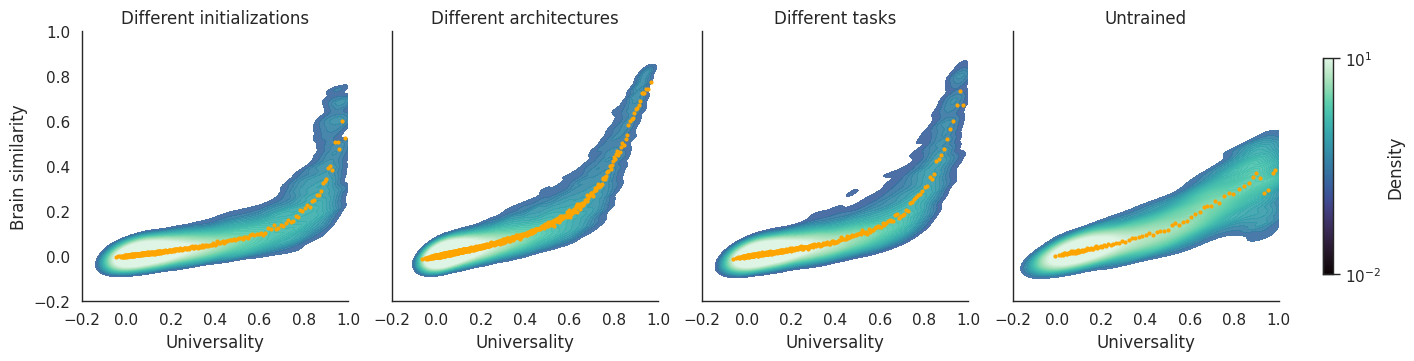

In [3]:
df = _load_main_results([0, 1, 2, 3,], "activation_pc", "NSD", roi="general")
with sns.plotting_context("paper", font_scale=1.25,):
    _plot_results_in_simple_grid(
        df=df, x="within_basis_ui", y="brain_similarity",
        main_plots=("line", "density",), group="model_set", group_order=_yielder_id([0, 1, 2, 3,], label=True),
        xlabel="Universality", ylabel="Brain similarity",
        log_kde=True,
        n_bin=0.01,
        # figname="fig_2",
    )

FIGURE3: layer-wise

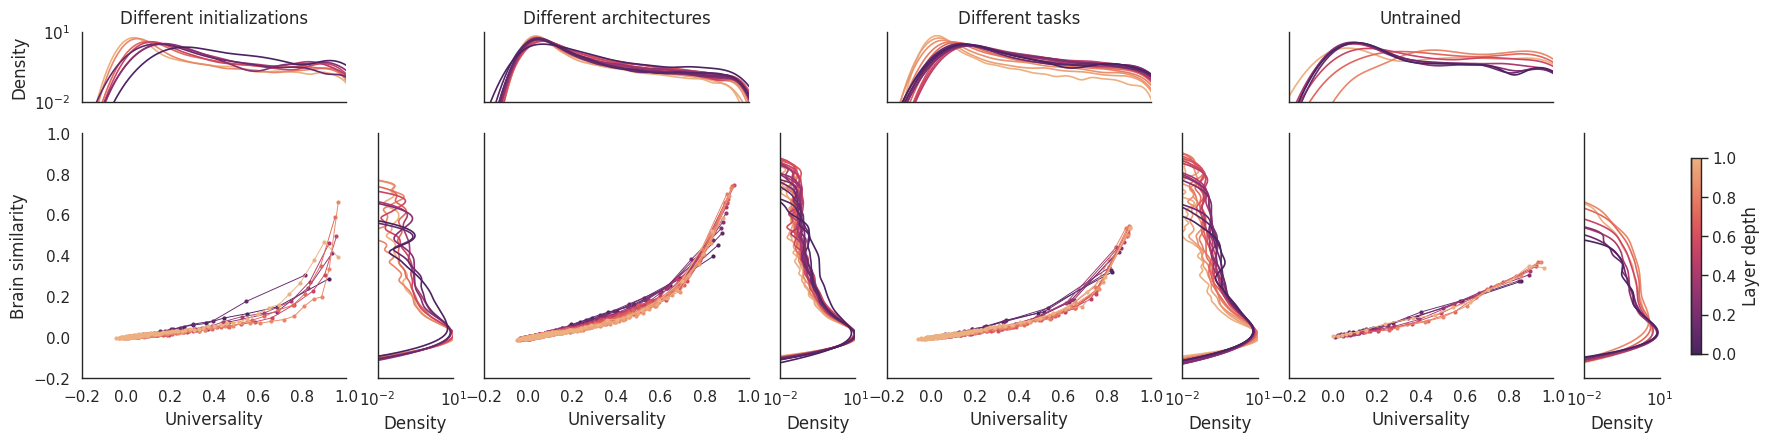

In [4]:
df = _add_node_depths(_load_main_results([0, 1, 2, 3], "activation_pc", "NSD", roi="general"))
df = df_lin_bin(df=df, col="node_depth", label_col="node_depth_bin", level="model_set", n_bin=20,)
with sns.plotting_context("paper", font_scale=1.25,):
    _plot_results_in_grid(
        df=df, x="within_basis_ui", y="brain_similarity",
        main_plots=("line",), group="model_set", group_order=_yielder_id([0, 1, 2, 3], label=True), 
        hue="node_depth_bin", hue_label="Layer depth", palette="flare_r", n_bin=.01,
        xlabel="Universality", ylabel="Brain similarity", 
        log_kde=True,
        # figname="fig_3",
    )

FIGURE4: see src/lib/analyses/pc_umap.py

FIGURE5: rsa

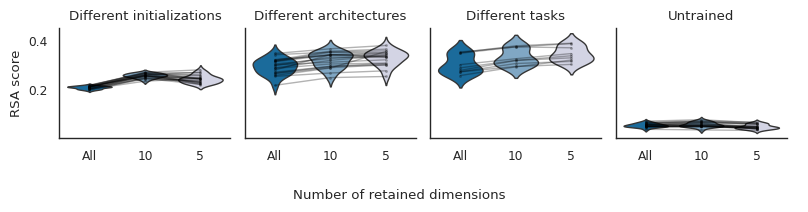

In [5]:
sort_by_ids = {
    "None": "All", 
    "within_basis_ui.n_top=10": "10", 
    "within_basis_ui.n_top=5": "5", 
}
_plot_rsas(sort_by_ids, [0, 1, 2, 3])

SUP1: per model

/tmp/ipykernel_3383390/3523477764.py:477: UserWarning: 
The palette list has fewer values (1) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/tmp/ipykernel_3383390/3523477764.py:477: UserWarning: 
The palette list has fewer values (1) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/tmp/ipykernel_3383390/3523477764.py:477: UserWarning: 
The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/tmp/ipykernel_3383390/3523477764.py:477: UserWarning: 
The palette list has fewer values (1) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


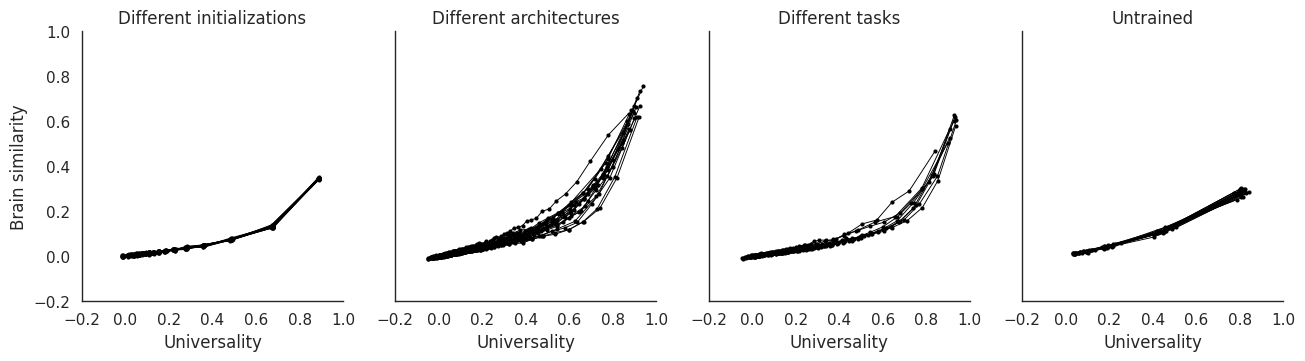

In [6]:
df = _load_main_results([0, 1, 2, 3], "activation_pc", "NSD", roi="general")
with sns.plotting_context("paper", font_scale=1.25,):
    _plot_results_in_simple_grid(
        df=df, x="within_basis_ui", y="brain_similarity",
        main_plots=("line",), group="model_set", group_order=_yielder_id([0, 1, 2, 3], label=True), hue="model",
        n_bin=.01,
        xlabel="Universality", ylabel="Brain similarity",
        log_kde=True, 
        # figname="sup_1",
    )

SUP2: per subject

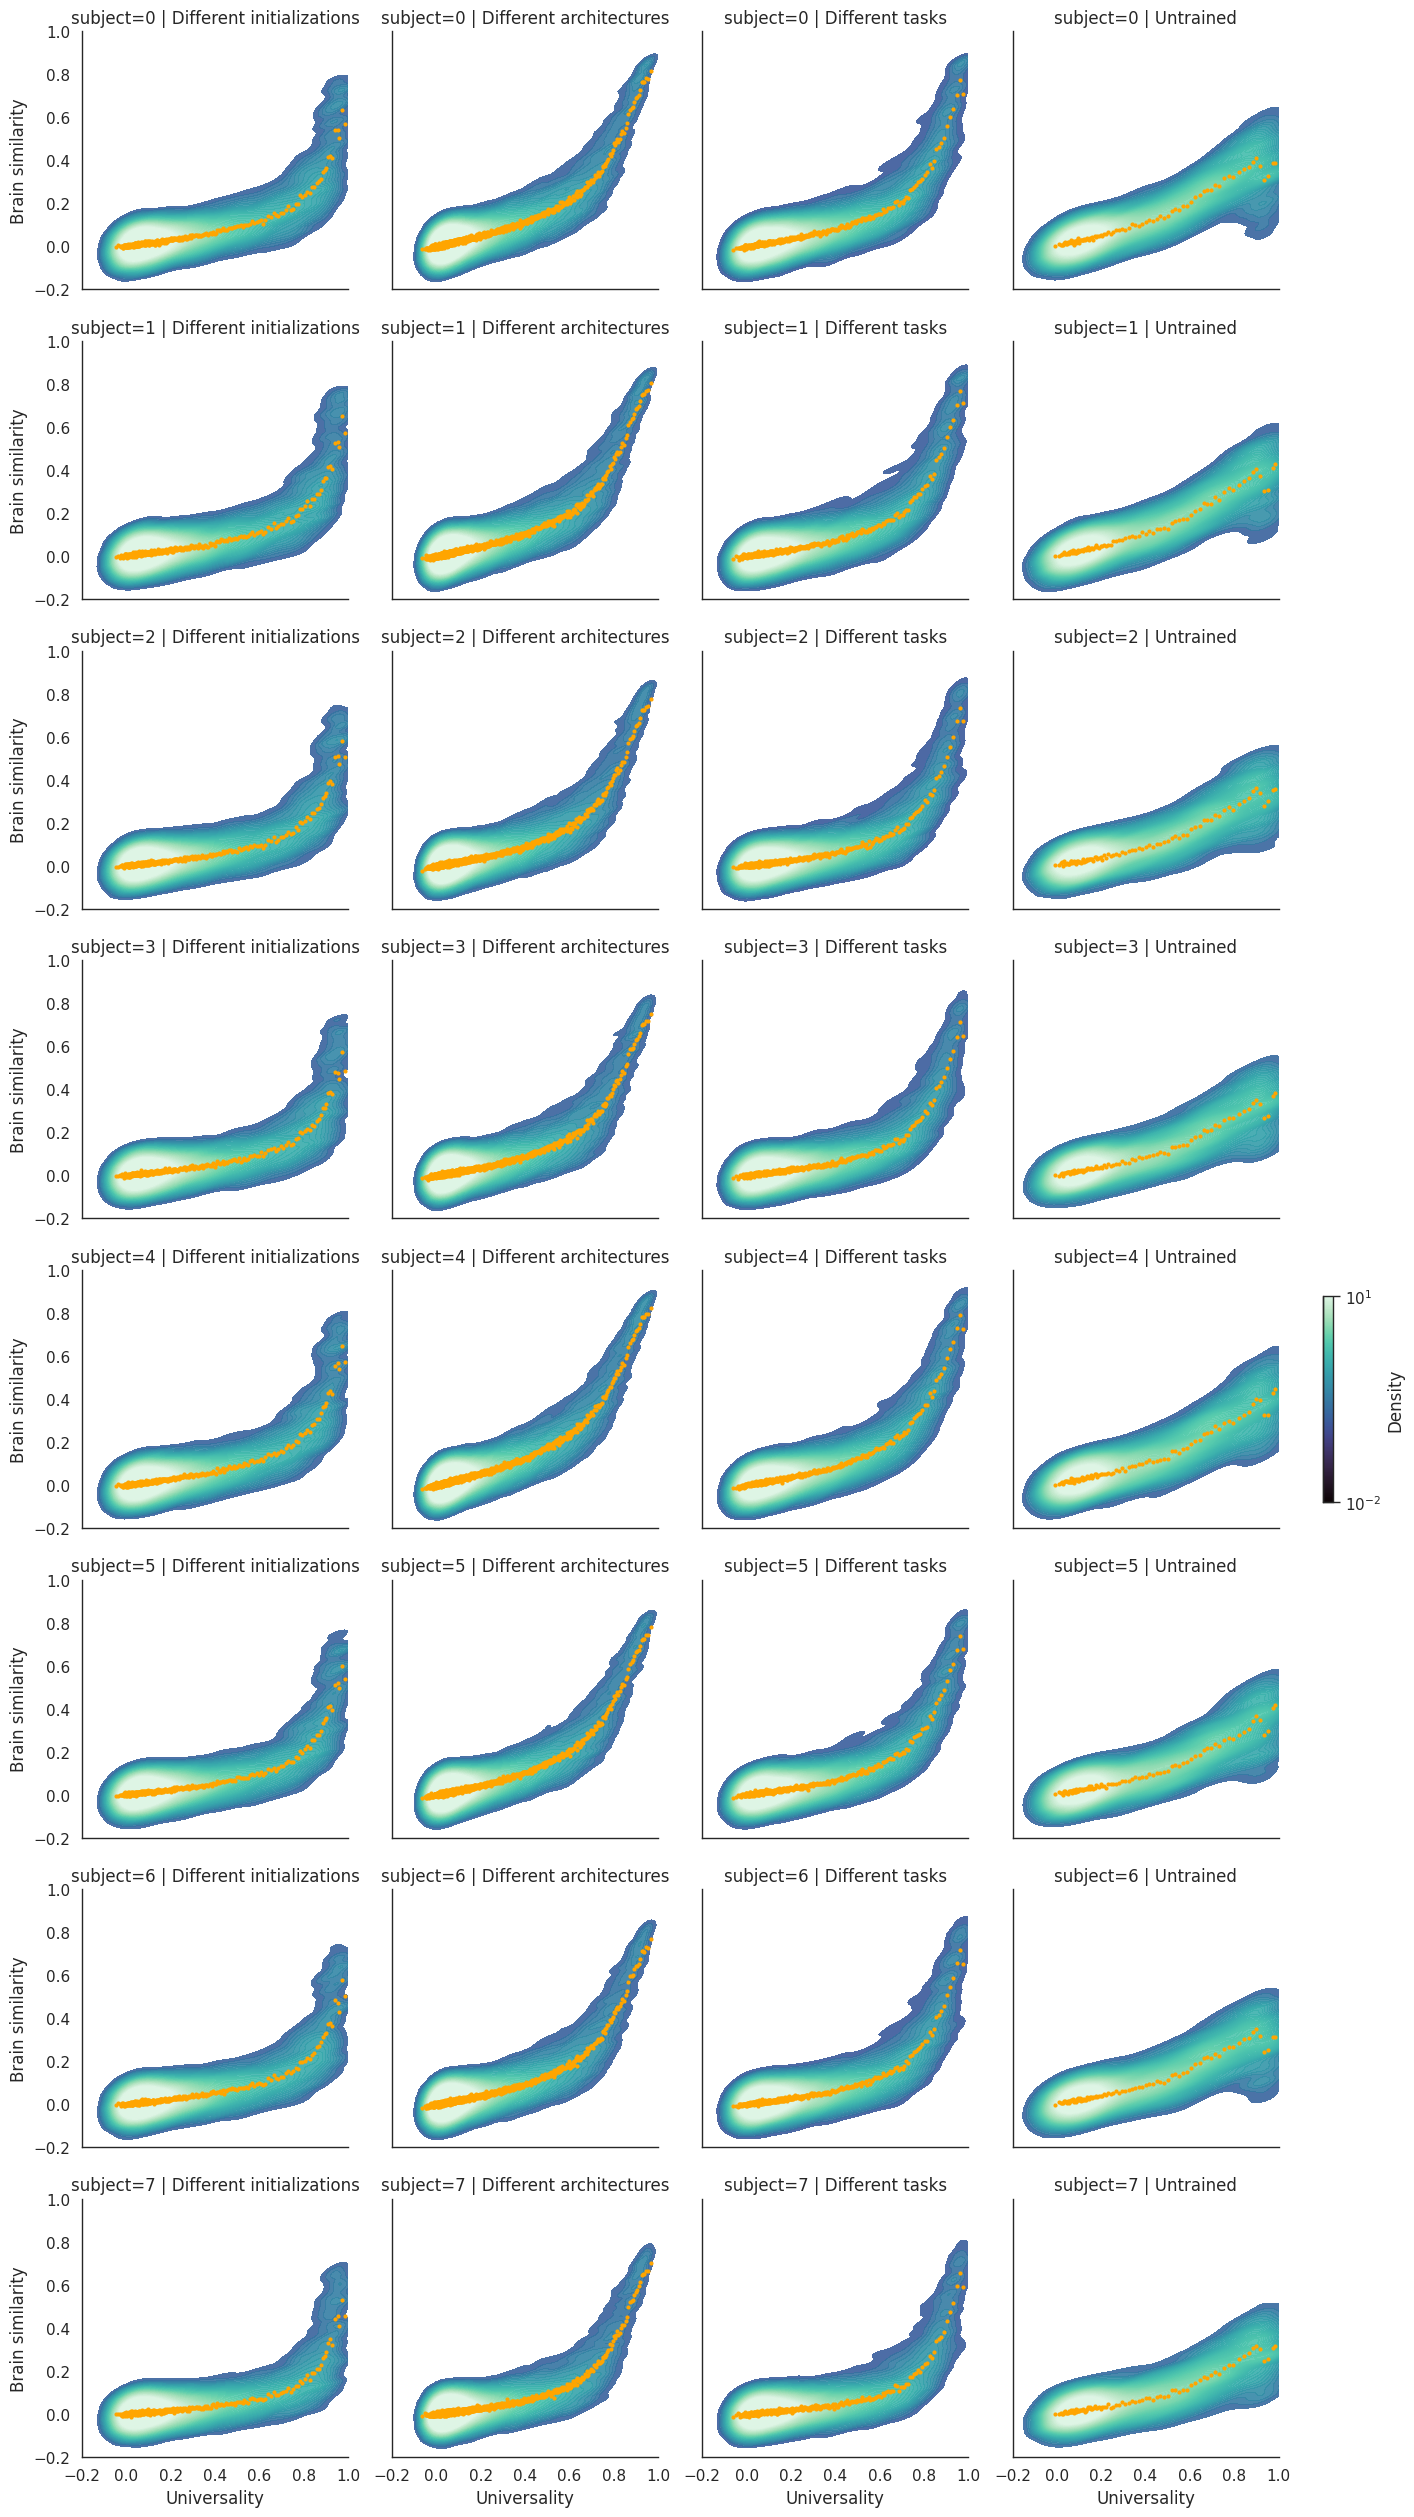

In [7]:
df = _load_main_results([0,1,2,3], "activation_pc", "NSD", roi="general", individual_subj=True,)
df["model_set+subject"] = [f"subject={df.subject[i]} | {df.model_set[i]}" for i in range(len(df))]
group_order = []
for s in range(8):
    for id in _yielder_id([0,1,2,3], label=True):
        group_order.append(f"subject={s} | {id}")
with sns.plotting_context("paper", font_scale=1.25,):
    _plot_results_in_simple_grid(
        df=df, x="within_basis_ui", y="brain_similarity",
        main_plots=("line", "density",), group="model_set+subject", group_order=group_order,
        xlabel="Universality", ylabel="Brain similarity",
        log_kde=True,
        n_bin=0.01,
        rowcol=(8, 4),
        # figname="sup_2",
    )

SUP3: roi-wise

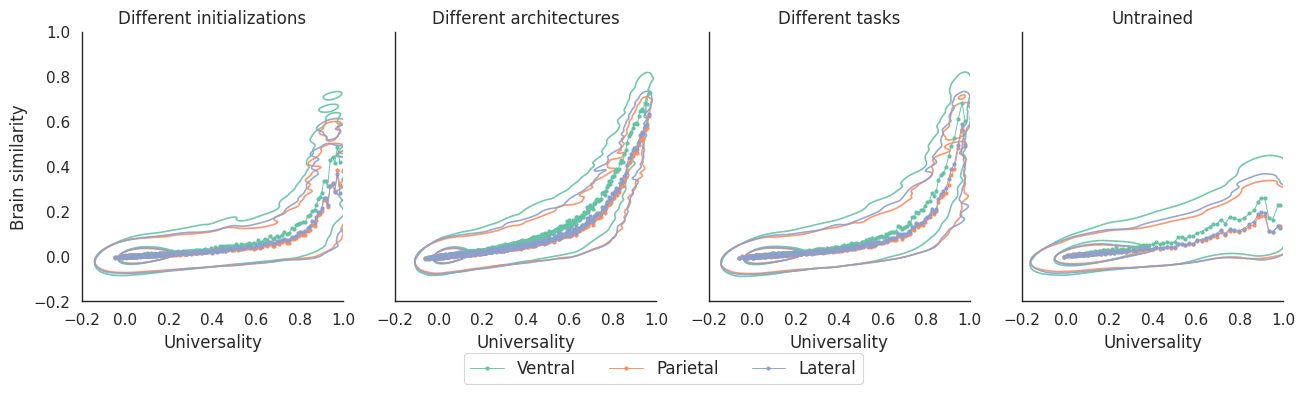

In [8]:
df = _load_main_results([0, 1, 2, 3,], "activation_pc", "NSD", roi="default_list")
streams = set([f"streams-{stream}" for stream in ["ventral","parietal","lateral",]])
with sns.plotting_context("paper", font_scale=1.25,):
    tdf = df[[r in streams for r in df.roi]]
    _plot_results_in_simple_grid(
        df=tdf, x="within_basis_ui", y="brain_similarity",
        main_plots=("line","density"), group="model_set", group_order=_yielder_id([0, 1, 2, 3,], label=True), hue="roi", palette="Set2", n_bin=.01,
        xlabel="Universality", ylabel="Brain similarity", legend="roi",
        log_kde=True,
        hue_order=[f"streams-{stream}" for stream in ["ventral","parietal","lateral",]],
        # figname="sup_3",
    )

SUP4: simulation

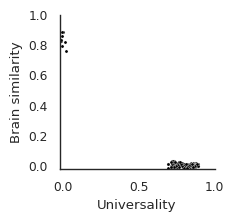

In [9]:
n_stim = 500
n_feature = 10
n_rep = 20
x, y = _simulation_data(n_stim, n_feature, n_rep)
rxx, rxy = _get_column_wise_rs(x, y, n_rep, n_rep,)
fig, ax = plt.subplots(figsize=(2, 2))
sns.scatterplot(x=rxx, y=rxy, ax=ax, marker="o", s=5, linewidth=.2, color="black")
_ = ax.set(xlabel="Universality", ylabel="Brain similarity", xlim=[-0.02, 1], ylim=[-0.02, 1])
sns.despine()

SUP5: alternative mapping

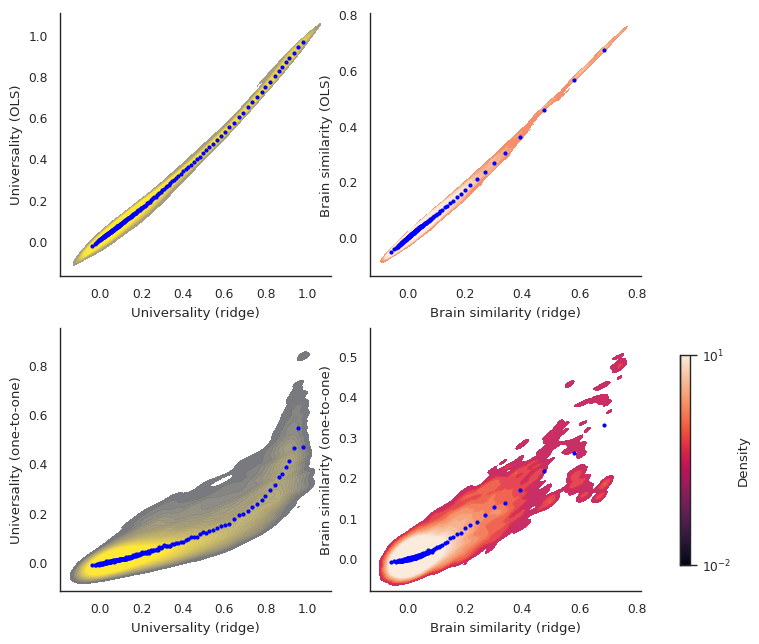

In [10]:
df = _load_main_results(0, "activation_pc", "NSD", roi="general",)
adfs = [
    _load_main_results(0, "activation_pc", "NSD", roi="general", reg="ols"),
    _load_main_results(0, "activation_pc", "NSD", roi="general", reg="one2one"),
]
adf_ids = ["ols", "one2one",]
for i, adf_id in enumerate(adf_ids):
    df[f"within_basis_ui_{adf_id}"] = adfs[i]["within_basis_ui"]
    df[f"brain_similarity_{adf_id}"] = adfs[i]["brain_similarity"]
_plot_mapping_comparison(df, adf_ids, ["OLS", "one-to-one",], ["cividis", "rocket"])

SUP6: adjusted brain similarity

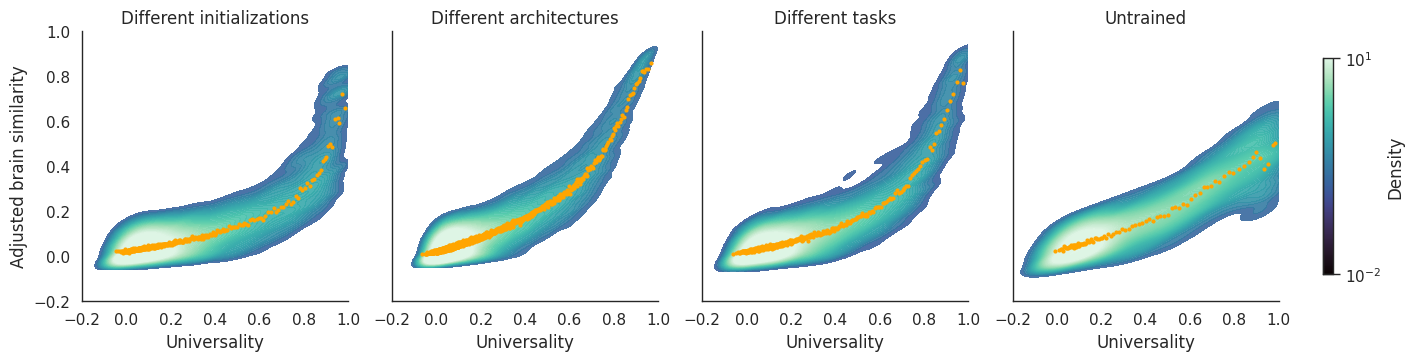

In [11]:
df = _load_main_results([0, 1, 2, 3], "activation_pc", "NSD", roi="general", sr=True)
df["adj_bs"] = df["brain_similarity"] / np.sqrt(df["cross_basis_ui"])
df.loc[df["brain_similarity"] < 0, "adj_bs"] = 0
df.loc[df["cross_basis_ui"] < 0, "adj_bs"] = 0
with sns.plotting_context("paper", font_scale=1.25,):
    _plot_results_in_simple_grid(
        df=df, x="within_basis_ui", y="adj_bs",
        main_plots=("line", "density",), group="model_set", group_order=_yielder_id([0, 1, 2, 3], label=True),
        xlabel="Universality", ylabel="Adjusted brain similarity",
        log_kde=True,
        n_bin=0.01,
    )

SUP7&8: see src/lib/analyses/pc_umap.py

SUP9: rsa per subject

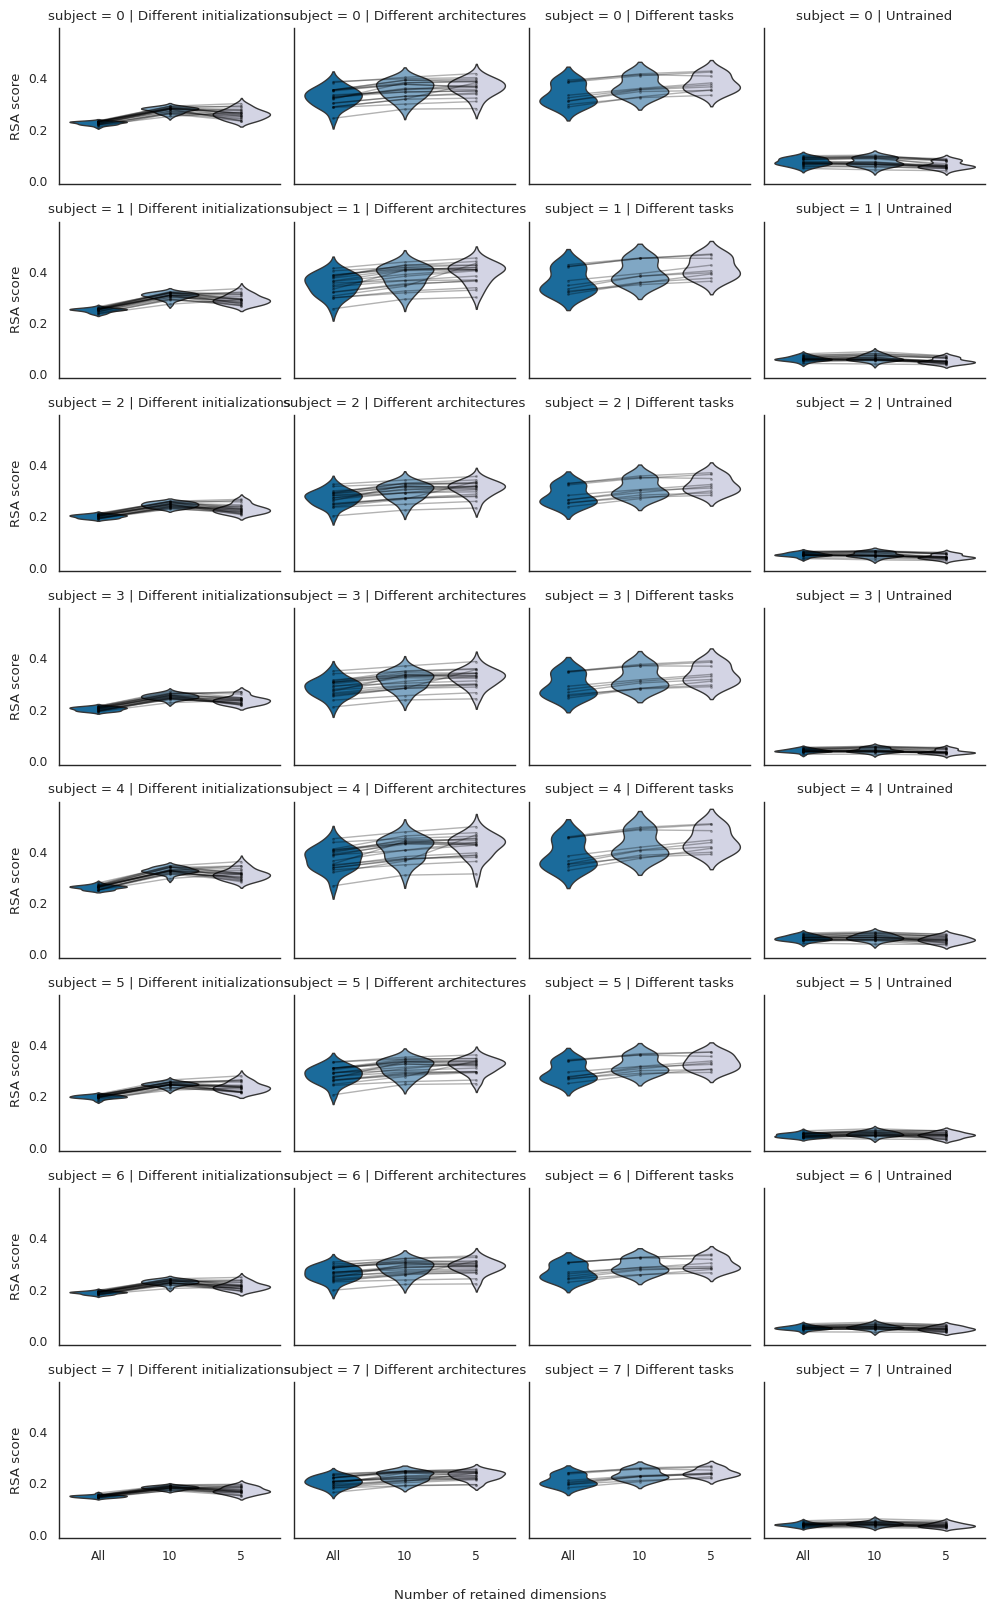

In [12]:
sort_by_ids = {
    "None": "All", 
    "within_basis_ui.n_top=10": "10", 
    "within_basis_ui.n_top=5": "5", 
}
_plot_rsas(sort_by_ids, [0, 1, 2, 3], individual="subject")

SUP10: rsa per roi

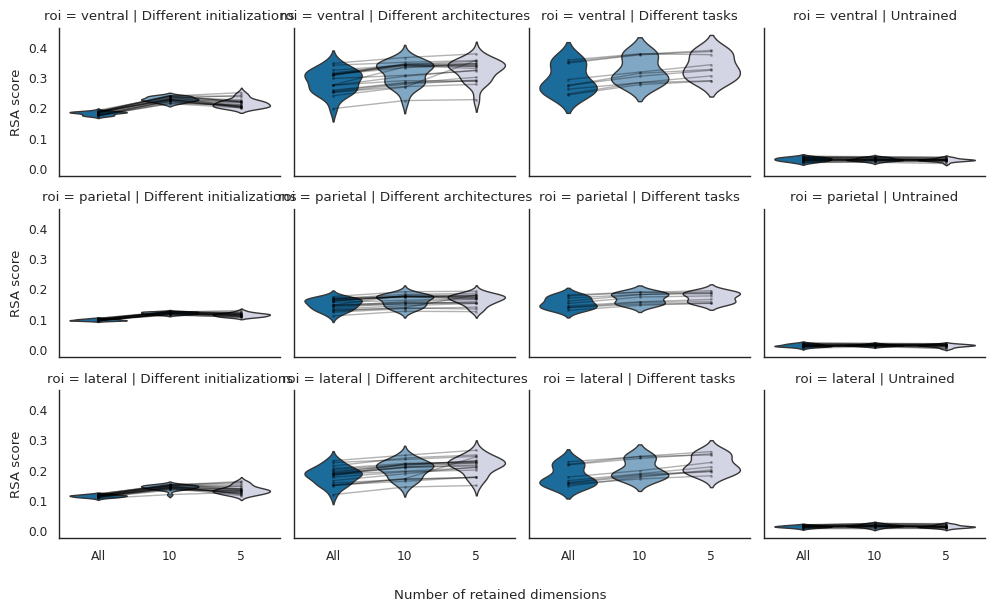

In [13]:
sort_by_ids = {
    "None": "All", 
    "within_basis_ui.n_top=10": "10", 
    "within_basis_ui.n_top=5": "5", 
}
_plot_rsas(sort_by_ids, [0, 1, 2, 3], individual="roi", individual_order=["ventral", "parietal", "lateral"])

SUP11: score distribution by pc rank

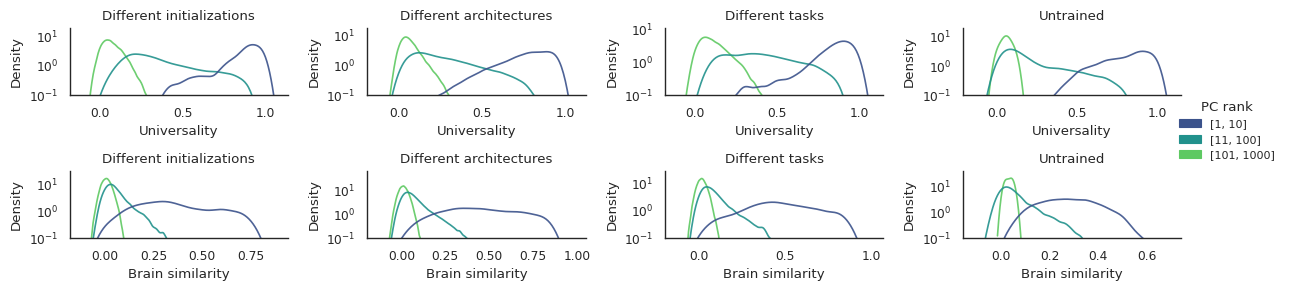

In [14]:
df = _load_main_results([0,1,2,3], "activation_pc", "NSD", roi="general")
df = df[df.pc <= 1000]
_plot_distribution(df)

SUP12: varied visual diets

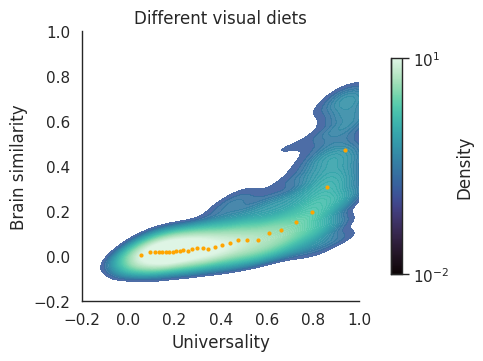

In [15]:
df = _load_main_results(4, "activation_pc", "NSD", roi="general",)
with sns.plotting_context("paper", font_scale=1.25,):
    _plot_results_in_simple_grid(
        df=df, x="within_basis_ui", y="brain_similarity",
        main_plots=("line", "density",), group="model_set", group_order=_yielder_id(4, label=True),
        xlabel="Universality", ylabel="Brain similarity",
        log_kde=True,
        rowcol=(1, 1),
        n_bin=0.01,
    )

STATS1: semantic alignment rsa

In [16]:
y_nt_no = [
    ("resnet50_imagenet1k_varied_tasks", 100, "layer4.1.relu_2"),
    ("resnet50_imagenet1k_varied_tasks", -100, "layer4.1.relu_2"),
    ("untrained_resnet18_varied_seeds", 100, "layer4.0.relu")
]
stim = "all"
df = []
r_ce = None
for yielder, ntop, node in y_nt_no:
    u = xr.open_dataarray(BONNER_CACHING_HOME / f"pc_umap/basis=activation_pc/regression=ridgecv/roi=general/mode=NSD/stim={stim}/yielder={yielder}/model=None/node={node}/sort_by=within_basis_ui.threshold=None=None/ntop={ntop}.nc")
    if r_ce is None:
        r_ce = torch.from_numpy(_r_ce(stim, u))
    u = torch.tensor(u.values)
    r_um = _flattend_tril(_euclid(u))
    df.append(pd.DataFrame.from_dict({
        "pearson_r": pearson_r(r_um, r_ce).item(),
        "yielder": yielder,
        "ntop": ntop,
        "node": [node],
    }))
df = pd.concat(df, axis=0).reset_index(drop=True)
df

,pearson_r,yielder,ntop,node
0,0.346714,resnet50_imagenet1k_varied_tasks,100,layer4.1.relu_2
1,0.001185,resnet50_imagenet1k_varied_tasks,-100,layer4.1.relu_2
2,0.034089,untrained_resnet18_varied_seeds,100,layer4.0.relu
